# Investigate transient neuron dynamics in Inception-v3

### Load measured variables

In [16]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

path = '/home/rbodo/.snntoolbox/data/imagenet/inceptionV3/lasagne/averagepool/log/gui/clamp'
debug_vars = np.load(os.path.join(path, 'debug_vars.npz'))
mem4 = debug_vars['mem4']
mem8 = debug_vars['mem8']
mem14 = debug_vars['mem14']
inputspiketimes4 = debug_vars['inputspikes4']
inputspiketimes8 = debug_vars['inputspikes8']
inputspiketimes14 = debug_vars['inputspikes14']
weights4 = debug_vars['weights4']
weights8 = debug_vars['weights8']
weights14 = debug_vars['weights14']
bias4 = debug_vars['bias4']  # 6th feature map
bias8 = debug_vars['bias8']  # 1st feature map
bias14 = debug_vars['bias14']  # 5th feature map
inputspikes4 = np.array(inputspiketimes4 > 0, 'int32')
inputspikes8 = np.array(inputspiketimes8 > 0, 'int32')
inputspikes14 = np.array(inputspiketimes14 > 0, 'int32')
dt = 1
T = int(len(mem8) * dt)
v_clamp = True
if v_clamp:
    t_clamp3 = 4
    t_clamp4 = 6
    t_clamp6 = 10
    t_clamp8 = 20
    t_clamp13 = 20
    t_clamp14 = 30
else:
    t_clamp3 = t_clamp4 = t_clamp6 = t_clamp8 = t_clamp13 = t_clamp14 = 0
v_clip = False

In [35]:
# Remove this cell when all old experiments in this script have been repeated (using new save-format)
######################################

% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

path = '/home/rbodo/.snntoolbox/data/imagenet/inception_averagepool/log/debug/init_bias'
mem8 = np.load(os.path.join(path, 'mem8.npy'))
mem14 = np.load(os.path.join(path, 'mem14.npy'))
inputspiketimes8 = np.load(os.path.join(path, 'inputspikes8.npy'))
inputspiketimes14 = np.load(os.path.join(path, 'inputspikes14.npy'))
weights8 = np.load(os.path.join(path, 'weights8.npy'))
weights14 = np.load(os.path.join(path, 'weights14.npy'))
bias8 = 0.23438094183802605
bias14 = 0.51390331238508224
inputspikes8 = (inputspiketimes8 > 0).astype('int')
inputspikes14 = (inputspiketimes14 > 0).astype('int')
dt = 1
T = int(len(mem8) * dt)
t_clamp3 = 0  # 4
t_clamp4 = 0  # 6
t_clamp6 = 0  # 10
t_clamp8 = 0  # 20
t_clamp13 = 0  # 20
t_clamp14 = 0  # 30

### Define helper functions.

In [3]:
from tests.other.googlenet.util import get_input_voltage, get_membrane_potential, get_rates, plot_cumsum, plot_spikerates, plot_spiketrains, plot_vmem

### Load target activations.

In [4]:
path_to_activations = '/home/rbodo/.snntoolbox/data/imagenet/inceptionV3/lasagne/averagepool/log/normalization/activations'
activations_batch4 = np.load(os.path.join(path_to_activations, '04Convolution2D_80x73x73.npz'))['arr_0']
activations_batch8 = np.load(os.path.join(path_to_activations, '08Convolution2D_48x35x35.npz'))['arr_0']
activations_batch14 = np.load(os.path.join(path_to_activations, '14Convolution2D_32x35x35.npz'))['arr_0']
activation4 = activations_batch4[0, 6, 3, 30] / 8.41  # Apply normalization
activation8 = activations_batch8[0, 0, 0, 0] / 7.1  # Apply normalization
activation14 = activations_batch14[0, 4, 0, 34] / 4.43  # Apply normalization

### Compute input voltages (PSP).

In [17]:
input4 = get_input_voltage(inputspikes4, weights4, bias4)
input8 = get_input_voltage(inputspikes8, weights8, bias8)
input14 = get_input_voltage(inputspikes14, weights14, bias14)

### Compute the membrane potential using input PSPs to validate the potentials measured during simulation. Get output spike times.

In [18]:
reset = 'sub'
mmem4, spikes4 = get_membrane_potential(input4, reset, t_clamp4)
mmem8, spikes8 = get_membrane_potential(input8, reset, t_clamp8)
mmem14, spikes14 = get_membrane_potential(input14, reset, t_clamp14)

### Check that computed and measured membrane potentials match.

In [19]:
mem_list = [mem4, mem8, mem14]
mmem_list = [mmem4, mmem8, mmem14]
results = []
for mem, mmem in zip(mem_list, mmem_list):
    results.append(np.isclose(mem - mmem, np.zeros_like(mem), atol=1e-4))
print(np.all(results))

False


### Plot spiketrains of input neurons.

In [8]:
plot_spiketrains([inputspiketimes4, inputspiketimes8, inputspiketimes14], ['3Pool', '6Pool', '13Pool'])

TypeError: plot_spiketrains() missing 1 required positional argument: 'path'

### Plot spike-rate of an input neuron over time.

In [9]:
t_clamp = [t_clamp3, t_clamp6, t_clamp13]
plot_spikerates([inputspiketimes4, inputspiketimes8, inputspiketimes14], ['3Pool', '6Pool', '13Pool'], t_clamp=t_clamp, idx=29, filename='spikerates_in')

TypeError: plot_spikerates() missing 3 required positional arguments: 'path', 'T', and 'dt'

### Plot cumulated input to layers vs time.

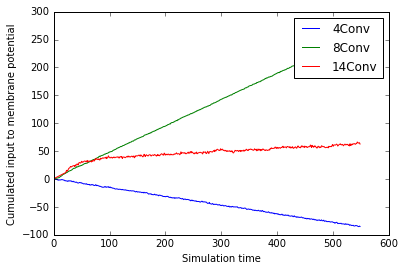

In [8]:
plot_cumsum([input4, input8, input14], ['4Conv', '8Conv', '14Conv'])

### Check that the cumulated input minus the number of spikes equals the residual membrane potential.

In [20]:
input_list = [input4, input8, input14]
num_spikes_list = [len(spikes4), len(spikes8), len(spikes14)]
mem_list = [mem4[-1], mem8[-1], mem14[-1]]
clamp_list = [t_clamp4, t_clamp8, t_clamp14]
results = []
for inp, num_spikes, mem, t_clamp in zip(input_list, num_spikes_list, mem_list, clamp_list):
    results.append(np.isclose(np.sum(inp[t_clamp:]) - num_spikes - mem, 0, atol=1e-4))
print(all(results))

False


### Plot membrane potential.

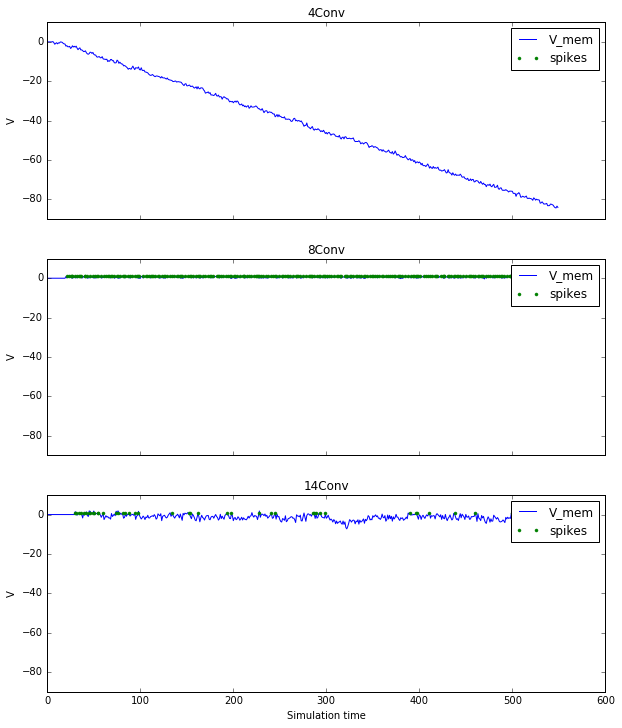

In [10]:
plot_vmem([mem4, mem8, mem14], [spikes4, spikes8, spikes14], ['4Conv', '8Conv', '14Conv'])

### Plot output spike-rates.

In [21]:
spiketimes4 = np.zeros((1, int(T/dt)))
spiketimes4[0, spikes4] = spikes4
spiketimes8 = np.zeros((1, int(T/dt)))
spiketimes8[0, spikes8] = spikes8
spiketimes14 = np.zeros((1, int(T/dt)))
spiketimes14[0, spikes14] = spikes14
t_clamp = [t_clamp4, t_clamp8, t_clamp14]
plot_spikerates([spiketimes4, spiketimes8, spiketimes14], ['4Conv', '8Conv', '14Conv'], [activation4, activation8, activation14], t_clamp=t_clamp, filename='spikerates_out')

TypeError: plot_spikerates() missing 2 required positional arguments: 'T' and 'dt'

### Combined plot for Frontiers paper

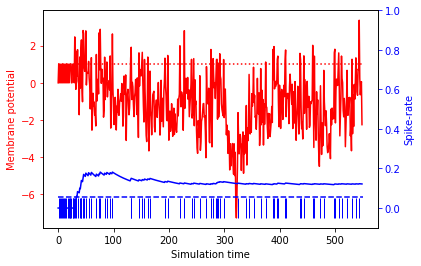

In [22]:
label = '14Conv'
t_clamp = t_clamp14
spiketimes = spiketimes14
activation = activation14
spikes = spikes14
m = np.copy(mem14)
m += np.array(spiketimes.flatten() > 0, 'int32')

rates = [0] * t_clamp
count = 0
t_idx = int(np.ceil(t_clamp/dt))
for t in np.arange(t_clamp, T, dt):
    count += int(spiketimes[0, t_idx] > 0)
    rates.append(count/(t+dt))
    t_idx += 1

f, ax1 = plt.subplots()
ax1.plot(np.arange(0, T, dt), m, label='V_mem', color='r')
ax1.hlines(1, 0, T, linestyle=':', color='r')
ax1.set_xlabel('Simulation time')
ax1.set_ylabel('Membrane potential', color='r')
ax1.tick_params('y', colors='r')
# ax1.set_xlim(0, 200)
# ax1.set_ylim(-35, None)

ax2 = ax1.twinx()
ax2.set_ylabel('Spike-rate', color='b')
ax2.plot(np.arange(0, T, dt), rates, label=label, color='b')
ax2.plot([s * dt for s in spikes], np.zeros_like(spikes), '|', markersize=20, label='spikes', color='b')
ax2.hlines(activation, 0, T, linestyle='--', label=label+'_target', color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylim(-0.1, 1)
# ax2.set_xlim(0, 200)

f.savefig(os.path.join(path, 'transient'), bbox_inches='tight')